## Feature Selection with sklearn and Pandas
[ref](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
3 methods used here
1. Filter Method
2. Wrapper Method
3. Embedded Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin as pda
import timeit

In [2]:
ctu13 = pd.read_csv('~/Desktop/My_files/S-4_SS21/Project/DataExploration/complete_all_scenarios_NoTransfer_withHeader_withLabel-29-8-2021-bak.csv')

ctu13_1 = ctu13

# Replace the label of normal traffic with 0
ctu13_1.loc[ctu13_1['Label'].str.contains('Normal') == True, 'Label'] = 0

# Replace the label of abnormal/botnet traffic with 1
ctu13_1.loc[ctu13_1['Label'].str.contains('Botnet') == True, 'Label'] = 1

def dataset_cleaning (dataset):
    
    for col in dataset.columns: #conver all values to number.(in the case any string is included)
        dataset[col]= pd.to_numeric(dataset[col],errors='coerce') #the error value force to put Nan if there is any error to convert string to value
        #dataset=dataset.dropna() # remove nan *Dropping the nans removes the corresponding rows as well, which would letter affect our data indices.
    dataset.fillna(dataset.median(), inplace=True) # Instead of dropping, fills NaNs with median vals
    scaler = MinMaxScaler()
    
    return pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)

ctu13_scaled = dataset_cleaning(ctu13_1)


/home/sudip/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def cl_sz_analyze (df, kmax, sample_sz_ar):
    """
    Analyze and plot WCSS and Silhouette Score for different cluster sizes. sample_sz_ar is an array of different
    sample sizes to perform Silhouette Scoring. Place [.., None] if sampling not required. 
    """
    
    # Elbow method
    wcss = [] # Within Cluster Squared Sum

    for i in range(1, kmax+1): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(df) 
        wcss.append(kmeans.inertia_)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

    # Plot Elbow graph
    ax1.plot(range(1, kmax+1), wcss, marker='v')
    ax1.set_title("Elbow graph")
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS')

    # Silhouette Scoring method
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    
    # loop over different sample sizes
    for sample in sample_sz_ar:
        start = timeit.default_timer()
        
        sil = []
        
        for k in range(2, kmax+1):
            kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42).fit(df)
            labels = kmeans.labels_
            sil.append(silhouette_score(df, labels, metric = 'euclidean', sample_size=sample))
        stop = timeit.default_timer()
              stop - start)
        
        # Plotting
        ax2.plot(range(2, kmax+1),sil, 
                 label="Whole dataset" if sample==None else "Sample size ={}".format(sample),
                marker='v')
        handles, labels = plt.gca().get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)

    plt.legend(newHandles, newLabels)
    ax2.set_title("Silhouette Score Comparison")
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('silhouette score')

    plt.show()
    return



In [4]:
# label the dataset according to k-means clustering
def get_new_label (df_scaled, labels, n_clusters):
    
    # Apply K-Means
    kmeans = KMeans(
        init="k-means++",
        n_clusters=n_clusters,
        random_state = 42
    )
    ctu13_transformed = kmeans.fit_transform(ctu13_coFt)

    
    # concat old Labels with scaled data 
    df_wl = pd.concat([df_scaled, labels], axis=1)
    
    # gets the cluster numbers of all of kmeans and converts to df
    x=pd.DataFrame(data=np.resize(kmeans.labels_, (len(kmeans.labels_),1)), columns=["Cluster no."]) 

    # concatinate the cluster number to the dataframe
    df_n_cl = pd.concat([df_wl, x], axis=1) 
    
    # get indexes of nodes at minimum distances from their clusters centers
    min_dist = pda(kmeans.cluster_centers_, df_scaled, metric='euclidean')

    # propagate label of center nodes
    df_n_cl['new_label']=labels
    for k in range(n_clusters):
        # get the old label of the node nearest to the corresponding center node
        label_center_node = df_n_cl.iloc[min_dist[k], df_n_cl.columns.get_loc("Label")] 

        # fill new_label with label of k where cluster number == k
        df_n_cl['new_label']=df_n_cl['new_label'].mask(df_n_cl['Cluster no.']==k,label_center_node)
    
    return df_n_cl

# get_new_label(ctu13_scaled, ctu13_1['Label'], 2).to_csv('ctu13_WnewLabels.csv')

### 1. Filter Method
Is done using [Pearson Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
<br>It is the ratio between the covariance of two variables and the product of their standard deviations.value between −1 and 1
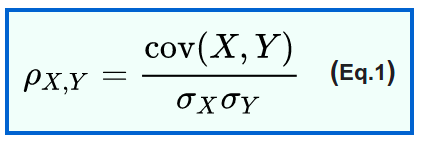

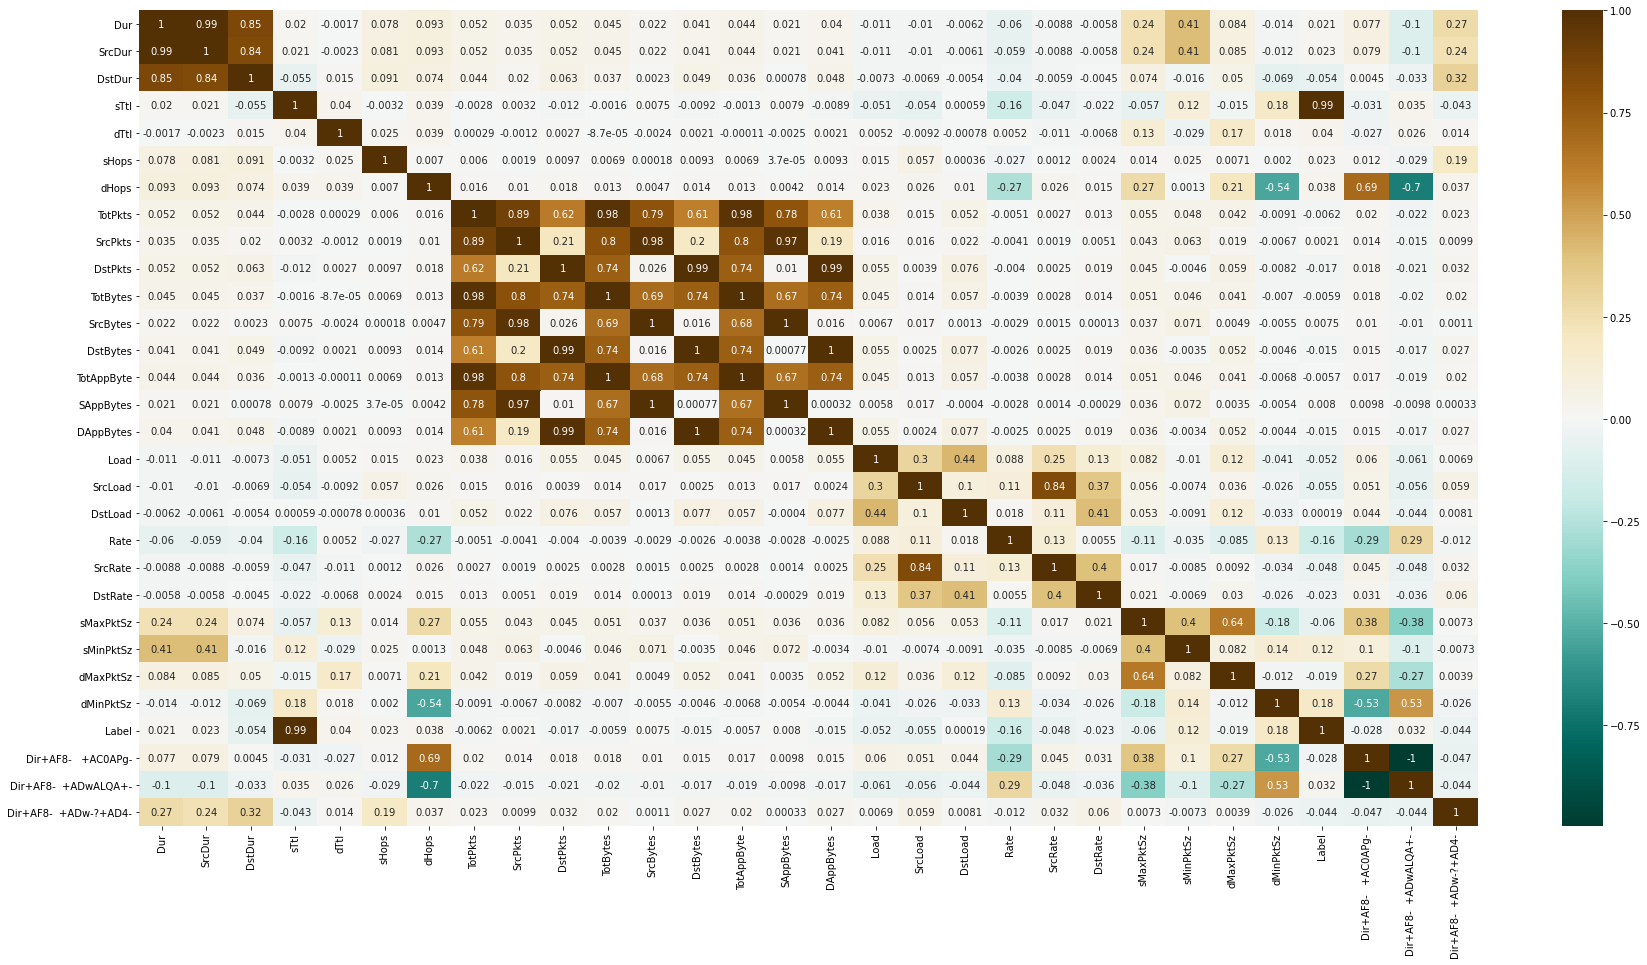

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(30,15))
cor = ctu13_scaled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.BrBG_r)

plt.savefig("pearson_corr_heatmap.jpg", dpi = 300)
plt.show()

In [6]:
#Correlation with output variable
cor_target = abs(cor['Label'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

DstDur       0.053630
sTtl         0.993779
Load         0.051886
SrcLoad      0.055145
Rate         0.164992
sMaxPktSz    0.059816
sMinPktSz    0.120703
dMinPktSz    0.183314
Label        1.000000
Name: Label, dtype: float64

Execution time with 1000 samples:  25.818560208000235


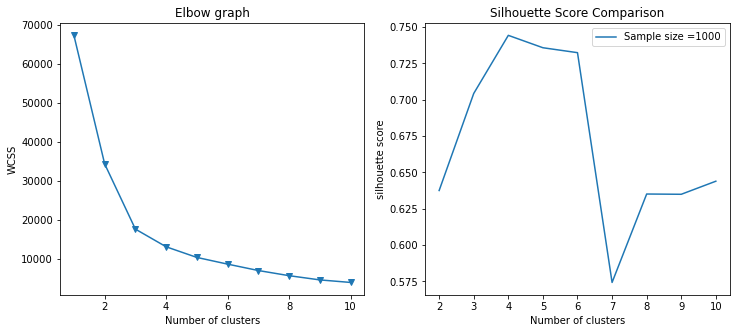

0.9969630380382625

In [7]:
ctu13_coFt = pd.concat([ctu13_scaled['DstDur'], ctu13_scaled['sTtl'], ctu13_scaled['Load'], 
                       ctu13_scaled['SrcLoad'], ctu13_scaled['Rate'], ctu13_scaled['sMaxPktSz'], 
                       ctu13_scaled['sMinPktSz'], ctu13_scaled['dMinPktSz']], axis=1)
cl_sz_analyze(ctu13_coFt, 10, [1000])
ctu13_wFtfilter = get_new_label(ctu13_coFt, ctu13_1['Label'], 6)
metrics.f1_score(ctu13_wFtfilter['Label'], ctu13_wFtfilter['new_label'])

### 2. Wrapper Method 
#### i. Backward Elimeination [ref](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
Eleminating worst performing features iteratively and compare performance.
<br>If the pvalue is above 0.05 then we remove the feature. 
<br> Note: OLS stands for ordinary least squares. 
Relationship between an independent variable (x) and dependent variable (y) is of the following form: y = mx + c
<br>OLS is an estimator in which the values of m and c (from the above equation) are chosen in such a way as to minimize the sum of the squares of the differences between the observed dependent variable and predicted dependent variable.

In [11]:
import statsmodels.api as sm

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(ctu13_1)
#Fitting sm.OLS model
model = sm.OLS(ctu13_1['Label'],X_1).fit()
model.pvalues

const                     9.920018e-01
Dur                       9.849046e-01
SrcDur                    9.948608e-01
DstDur                    9.888257e-01
sTtl                      9.997479e-01
dTtl                      9.288915e-01
sHops                     9.952086e-01
dHops                     9.994499e-01
TotPkts                   3.381917e-04
SrcPkts                   1.980335e-02
DstPkts                   1.703606e-02
TotBytes                  0.000000e+00
SrcBytes                  0.000000e+00
DstBytes                  0.000000e+00
TotAppByte                0.000000e+00
SAppBytes                 0.000000e+00
DAppBytes                 0.000000e+00
Load                      1.344848e-54
SrcLoad                   6.503649e-06
DstLoad                  9.136990e-159
Rate                      8.733684e-01
SrcRate                   9.861114e-01
DstRate                   9.084138e-01
sMaxPktSz                 9.973408e-01
sMinPktSz                 9.813709e-01
dMaxPktSz                

In [16]:
#Backward Elimination
cols = list(ctu13_1.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = ctu13_1[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(ctu13_1['Label'],X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)


['Dur', 'SrcDur', 'TotPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'TotAppByte', 'SAppBytes', 'DAppBytes', 'Load', 'SrcLoad', 'DstLoad', 'Label']


In [28]:
ctu13_BE = pd.DataFrame()
for col in selected_features_BE:
    ctu13_BE=ctu13_BE.join(other=ctu13_1[col], how='right')

In [29]:
ctu13_BE

,Dur,SrcDur,TotPkts,TotBytes,SrcBytes,DstBytes,TotAppByte,SAppBytes,DAppBytes,Load,SrcLoad,DstLoad,Label
0,0.000000,0.000000,1,141,141,0,99,99,0,0.000000,0.000000,0.000000,0
1,0.000000,0.000000,1,247,247,0,205,205,0,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,1,173,173,0,131,131,0,0.000000,0.000000,0.000000,0
3,0.000291,0.000000,2,207,72,135,123,30,93,0.000000,0.000000,0.000000,0
4,0.000321,0.000000,2,247,72,175,163,30,133,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513591,0.018230,0.018230,6,412,272,140,0,0,0,120241.359375,89522.765625,61837.457031,0
513592,0.018535,0.018535,6,412,272,140,0,0,0,118262.750000,88049.640625,59084.195312,0
513593,0.202575,0.177784,10,1219,549,670,543,211,332,38543.750000,19799.306641,24100.855469,0
513594,0.018334,0.018334,6,412,272,140,0,0,0,119559.289062,89014.945312,60579.839844,0


In [30]:
ctu13_BE_scaled = dataset_cleaning(ctu13_BE)

Execution time with 10000 samples:  35.80770477399892


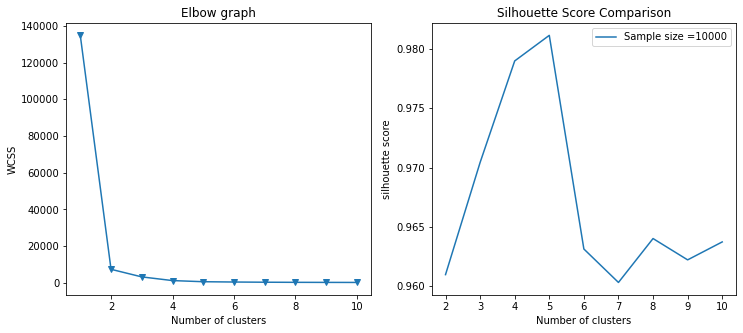

In [31]:
cl_sz_analyze(ctu13_BE_scaled, 10, [10000])

In [33]:
ctu13_wlBE = get_new_label(ctu13_coFt, ctu13_1['Label'], 2)
metrics.f1_score(ctu13_wlBE['Label'], ctu13_wlBE['new_label'])

0.9994971664164428